# Valuing Off-the-ball Movement

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/rjtavares/football-crunching/blob/master/notebooks/valuing%20off%20the%20ball%20movement.ipynb"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>&nbsp;<br></br>Movement is one of the most important dimensions of Football, but it is notoriously hard to measure.

Take Cristiano Ronaldo. He is often criticized for scoring lots of tap ins (even has an Urban dictionary page for it), but that is often result of his great movement, not just the creativity of his teammates.

For this notebook, we will use [this example](https://www.youtube.com/watch?v=Ws9qzQdv8QQ): Ronaldo’s Calma goal for Real Madrid against Barcelona.

We will use positional data from Last Row (you can watch the full animation for the same goal [here](https://www.youtube.com/watch?v=P0gqowlSxTw)) and common Python libraries: pandas, matplotlib, scipy and shapely.

First, let's take care of the basics: imports and from handy funtions to handle the drawing. You can learn more about these in our other notebooks (*working with positional data* and *using voronoi diagrams*).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patheffects as path_effects
from scipy.spatial import Voronoi

from shapely.ops import cascaded_union
from shapely.geometry import Polygon, MultiPoint
from shapely import affinity

%matplotlib inline
plt.style.use('ggplot')

## Loading Data

In [2]:
play = '../datasets/positional_data/Real_vs_Barcelona_Calma.csv'

df = pd.read_csv(play, index_col=1)

df.head()

,player,x,y,z,dx,dy,coords,player_num,player_obj,team,num,name,edgecolor,bgcolor
frame,,,,,,,,,,,,,,
0,0,38.217627,15.961068,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,37.447818,15.742122,0.0,-0.769809,-0.218947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,36.729118,15.537712,0.0,-0.718700,-0.204410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,36.058134,15.346873,0.0,-0.670984,-0.190839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,35.431698,15.168704,0.0,-0.626436,-0.178169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Drawing the basic pitch

In [3]:
X_SIZE = 105.0
Y_SIZE = 68.0

BOX_HEIGHT = (16.5*2 + 7.32)/Y_SIZE*100
BOX_WIDTH = 16.5/X_SIZE*100

GOAL = 7.32/Y_SIZE*100

GOAL_AREA_HEIGHT = 5.4864*2/Y_SIZE*100 + GOAL
GOAL_AREA_WIDTH = 5.4864/X_SIZE*100

SCALERS = np.array([X_SIZE/100, Y_SIZE/100])

def draw_pitch(dpi=100):
    """Sets up field
    Returns matplotlib fig and axes objects.
    """

    fig = plt.figure(figsize=(12.8, 7.2), dpi=dpi) #(X_SIZE/10, Y_SIZE/10)
    fig.patch.set_facecolor('#a8bc95') #complementary: #80a260 e #95bbbc, opposing: #bc95a8 & #bc9f95

    axes = fig.add_subplot(1, 1, 1)
    axes.set_axis_off()
    axes.set_facecolor('#a8bc95')
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

    axes.set_xlim(0,100)
    axes.set_ylim(0,100)

    plt.xlim([-13.32, 113.32])
    plt.ylim([-5, 105])

    fig.tight_layout(pad=3)

    draw_patches(axes)

    return fig, axes

def draw_patches(axes):
    """
    Draws basic field shapes on an axes
    """
    #pitch
    axes.add_patch(plt.Rectangle((0, 0), 100, 100,
                       edgecolor="white", facecolor="none"))

    #half-way line
    axes.add_line(plt.Line2D([50, 50], [100, 0],
                    c='w'))

    #penalty areas
    axes.add_patch(plt.Rectangle((100-BOX_WIDTH, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                               ec='w', fc='none'))

    #goal areas
    axes.add_patch(plt.Rectangle((100-GOAL_AREA_WIDTH, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                               ec='w', fc='none'))

    #goals
    axes.add_patch(plt.Rectangle((100, (100-GOAL)/2),  1, GOAL,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL)/2),  -1, GOAL,
                               ec='w', fc='none'))


    #halfway circle
    axes.add_patch(Ellipse((50, 50), 2*9.15/X_SIZE*100, 2*9.15/Y_SIZE*100,
                                    ec='w', fc='none'))

    return axes

## Drawing Players and the Ball

0

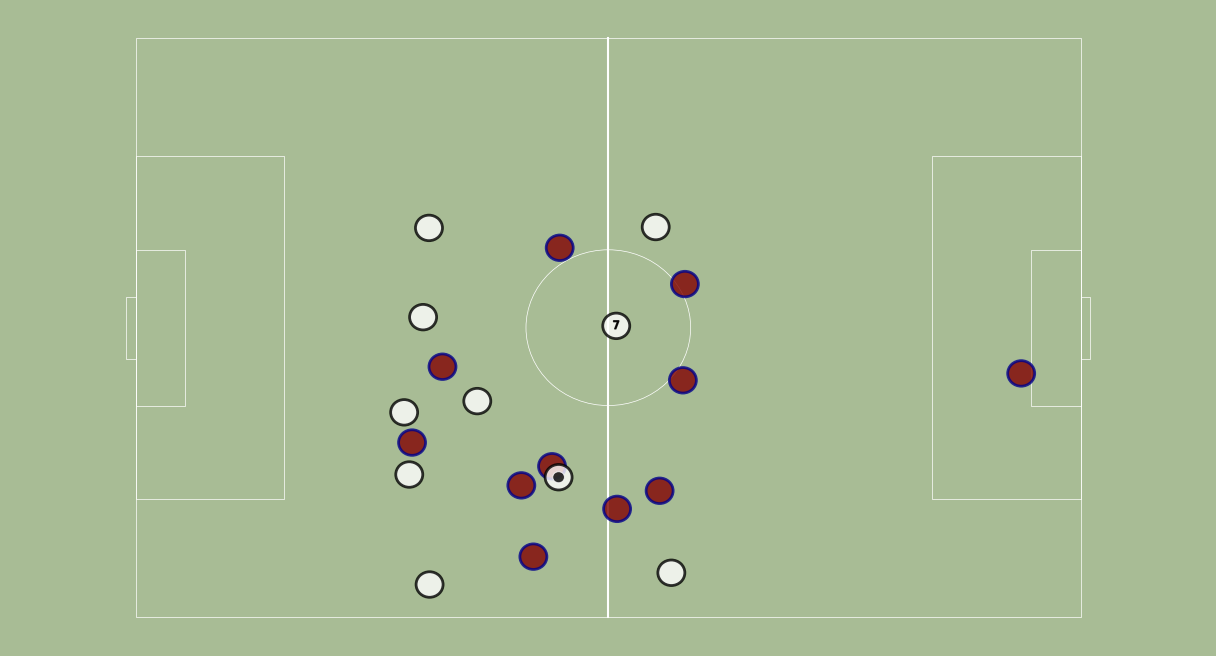

In [4]:
def draw_frame(df, t, text_color='black'):
    f = int(t*20)
    fig, ax = draw_pitch()
    dfFrame = df.loc[f].copy()

    for i, row in dfFrame.iterrows():
        if row['player']==0:
            try:
                z = row['z']
            except:
                z = 0
            size = 1.3+z
            lw = 0.7
            color='black'
            edge='white'
            zorder = 100
        else:
            #formatting for players
            size = 3
            lw = 2
            edge =  row['edgecolor']

            color = row['bgcolor']
            if row['team']=='attack':
                zorder = 21
            else:
                zorder = 20

        ax.add_artist(Ellipse((row['x'],
                               row['y']),
                              size/X_SIZE*100, size/Y_SIZE*100,
                              edgecolor=edge,
                              linewidth=lw,
                              facecolor=color,
                              alpha=0.8,
                              zorder=zorder))

        s = row['player_num']
        if not(pd.isnull(s)):
            if isinstance(s, float):
                s=int(s)
            text = plt.text(row['x'],row['y'],str(s),
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=8, color=text_color, zorder=22, alpha=0.8)

            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground=text_color, alpha=0.8),
                                   path_effects.Normal()])

    return fig, ax, dfFrame

draw_frame(df, 4.1)
0

# Drawing a Voronoi diagram

In [5]:
direction = -1

def calculate_voronoi(dfFrame, future=0):
    dfTemp = dfFrame.copy().set_index('player').drop(0, errors='ignore')
    dfTemp.x = dfTemp.x+dfTemp.dx*future*20
    dfTemp.y = dfTemp.y+dfTemp.dy*future*20
    values = np.vstack((dfTemp[['x', 'y']].values*SCALERS,
                        [-1000,-1000],
                        [+1000,+1000],
                        [+1000,-1000],
                        [-1000,+1000]
                       ))

    vor = Voronoi(values)

    dfTemp['region'] = vor.point_region[:-4]

    return vor, dfTemp

pitch = Polygon(((0,0), (0,100), (100,100), (100,0)))

def draw_voronoi(df, t):
    fig, ax, dfFrame = draw_frame(df, t)
    vor, dfVor = calculate_voronoi(dfFrame)
    polygons = {}
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS).intersection(pitch)
                    color = pl['bgcolor'].values[0]
                    x, y = polygon.exterior.xy
                    plt.fill(x, y, c=color, alpha=0.30)
                    polygons[pl.index[0]] = polygon
                except IndexError:
                    pass
                except AttributeError:
                    pass

        plt.scatter(dfVor['x'], dfVor['y'], c=dfVor['bgcolor'], alpha=0.2)
    return fig, ax, dfFrame, polygons

Let's start by showing the Voronoi diagrams for the two key moments: the pass (t=6.5) and the reception (t=9.0)

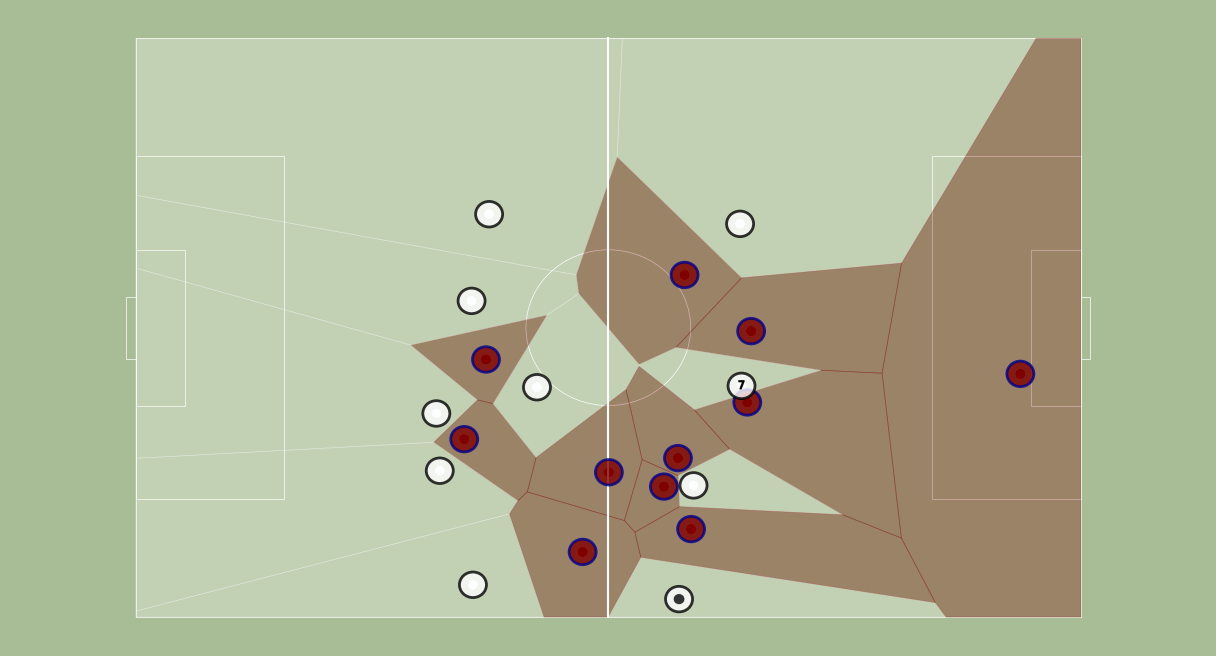

In [6]:
fig, ax, dfFrame, polygons = draw_voronoi(df, t=6.5)

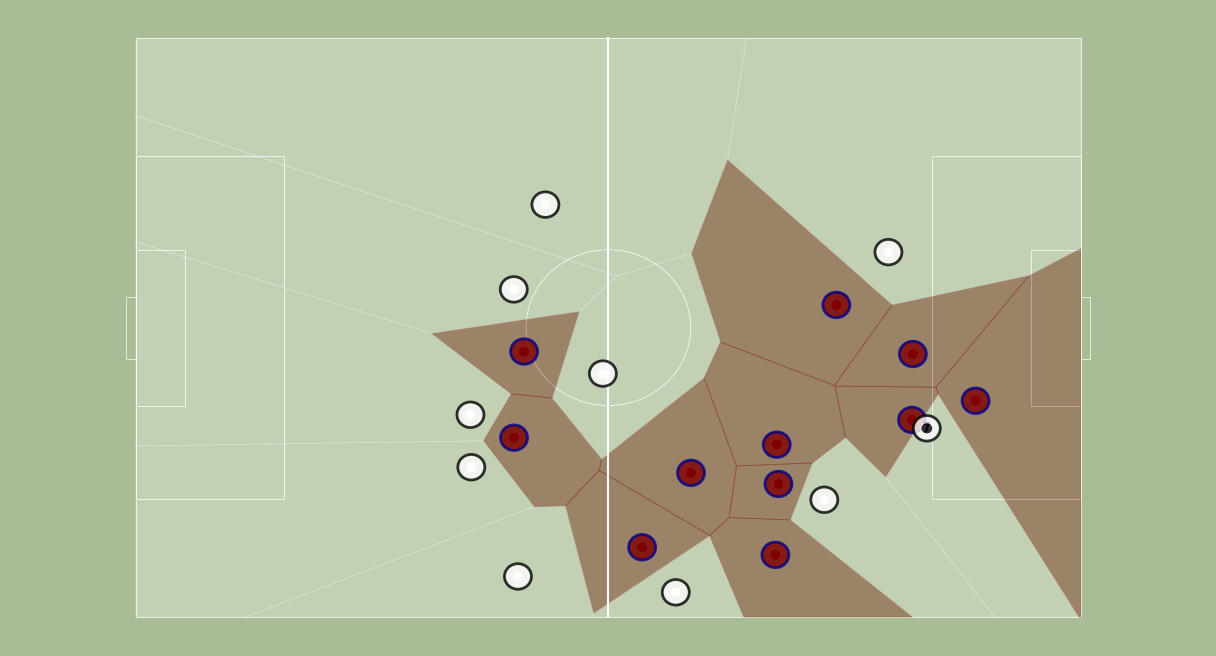

In [7]:
fig, ax, dfFrame, polygons = draw_voronoi(df, t=9.0)
reception_coords = dfFrame[dfFrame.player==12][['x','y']]


At the moment the pass is made, Ronaldo doesn’t have much space to receive the ball, with two defenders covering most of the space. However, he’s moving at a faster speed — something you can’t see in the frame — and that’s why he gets to the ball before the defenders.

## Speed or Anticipation?

One possible explanation for why Ronaldo gets past the defenders is his maximum speed. If he, at peak, runs faster than the defenders, he will always get an edge.

Of course, our data isn’t precise or large enough to properly test this theory, but let’s look at what we got: below is a plot of the speed of Ronaldo and the two defenders on him during the play:

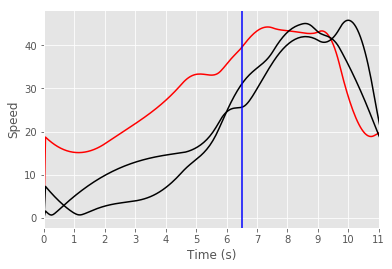

In [8]:
players = [12, 7347, 7345] # player_id 12 is the attacker; ids 7347 and 7346 the two defenders closest to the attacker

df['d'] = np.sqrt(np.square(df.dx*X_SIZE)+np.square(df.dy*Y_SIZE))

for p in players:
    if p!=0:
        if p==12:
            color='red'
        else:
            color='black'
        dfPlot = df.loc[df.player==p]
        plt.plot(dfPlot.d, color=color)
        plt.xlim(0, 11*20)
        
plt.xticks(np.arange(0, 240, 20), np.arange(0, 12))
plt.xlabel('Time (s)')
plt.ylabel('Speed')

plt.axvline(6.5*20, color='blue')

As you can see, the max speeds of the three players are comparable, but Ronaldo noticeably starts accelerating before the defenders do, and also hits maximum speed before they do. Most importantly, at the time of the pass (blue vertical line) Ronaldo is moving faster than both defenders, and they take more than one second to fully catch up.

**Conclusion:** current position may not be the best input to build our Voronois.

> Johan Cruyff: “What is speed? The sports press often confuses speed with insight. See, if I start running slightly earlier than someone else, I seem faster.”

Let’s incorporate this concept into the Voronoi graphic, simplifying by assuming all players maintain current speed and direction.

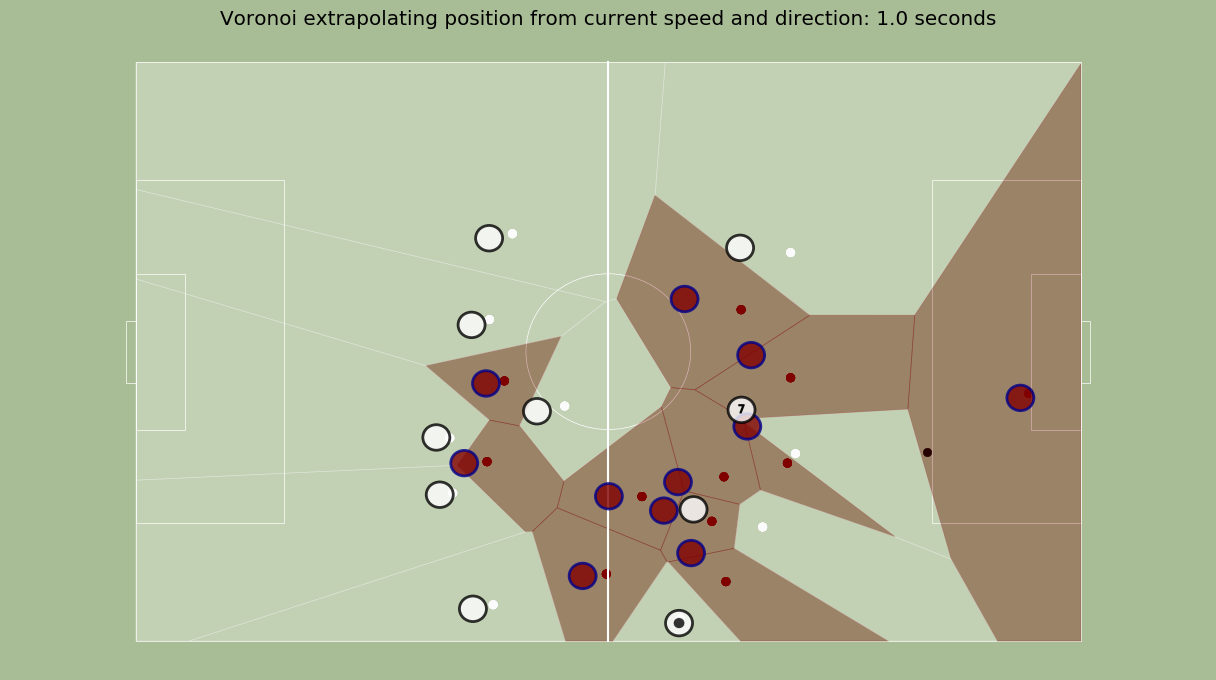

In [9]:
#chage the draw_voronoi function to accept another argument: future, the number of seconds used to extrapolate predicted future positions
def draw_voronoi(df, t, future=0):
    fig, ax, dfFrame = draw_frame(df, t)
    vor, dfVor = calculate_voronoi(dfFrame, future)
    polygons = {}
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS).intersection(pitch)
                    color = pl['bgcolor'].values[0]
                    x, y = polygon.exterior.xy
                    plt.fill(x, y, c=color, alpha=0.30)
                    polygons[pl.index[0]] = polygon
                except IndexError:
                    pass
                except AttributeError:
                    pass

        plt.scatter(dfVor['x'], dfVor['y'], c=dfVor['bgcolor'], alpha=0.2)
    return fig, ax, dfFrame, polygons

fig, ax, dfFrame, polygons = draw_voronoi(df, t=6.5, future=1)
plt.title('Voronoi extrapolating position from current speed and direction: 1.0 seconds')
plt.scatter(*reception_coords.values[0], c='black')

In [10]:
#saving versions assuming different time periods to the extrapolation
for i in range(40):
    fig, ax, dfFrame, polygons = draw_voronoi(df, t=6.5, future=i/20)
    plt.title('Voronoi extrapolating position from current speed and direction: {:.2f} seconds'.format(i/20))
    plt.scatter(*reception_coords.values[0], c='black')
    fig.savefig('output/frame{}.jpg'.format(i+100), facecolor='#a8bc95')
    
plt.close('all')

C:\Users\Ricardinho\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


This is a complex issue. You can have to take into account current speed and direction, reaction time, and maximum velocity, and all of these factors would be different for each individual player. Some wouldn’t even be constant for a player— e.g. line of sight would impact reaction time. For a more complex and realistic model, check out [William Spearman’s Pitch Control model](http://www.sloansportsconference.com/wp-content/uploads/2018/02/2002.pdf).

# Incorporating Movement in the Potential Threat Model

In a [previous post](https://medium.com/football-crunching/calculating-threat-potential-from-positional-data-3a674f61b88) (also available as notebook in this repository), I used Voronoi Diagrams and Karun Singh’s [Expected Threat model](https://karun.in/blog/expected-threat.html) to calculate **Threat Potential** - basically, the idea is to **add the expected threat on all zones controlled by the attacking team**.

Let’s take the two versions of the Voronoi Diagrams — Current and Extrapolated (we’ll use the 1 second version) — and calculate the Potential Threat on both versions.

In [11]:
import json

#loading the json file with the xT values for each zone of the pitch 
with open('../datasets/open_xt_12x8_v1.json', 'r') as f:
    xTvalues = np.array(json.load(f))
    
def offset_df(df, dx, dy):
    df = df.copy()
    df.x = df.x+dx
    df.y = df.y+dy  
    return df

dfxT = df.from_records(xTvalues).unstack().reset_index()
dfxT.columns = ['x', 'y', 'xT']

dfxT = pd.concat([offset_df(dfxT, dx, dy)
                  for dx, dy
                  in [(0.25, 0.25), (0.25, 0.75), (0.75, 0.25), (0.75, 0.75)]
                 ])

ny, nx = xTvalues.shape

dfxT.x = dfxT.x*100/nx
dfxT.y = dfxT.y*100/ny

#only consider locations with better than median threat (i.e. ignore defensive positions)
dfxT.xT = np.clip(dfxT.xT-dfxT.xT.median(), 0, 1)

#flip axis if necessary (to align with attacking team)
#dfxT.x = 100-dfxT.x
#dfxT.y = 100-dfxT.y

points = MultiPoint(list(zip(dfxT['x'], dfxT['y'])))
dfValues = dfxT.set_index(['x', 'y'])

def calculate_value(df, t, future=0):
    f = int(t*20)
    dfFrame = df.loc[f]
    vor, dfVor = calculate_voronoi(dfFrame, future)
    polygons = {}
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS).intersection(pitch)
                    polygons[pl.index[0]] = polygon
                except IndexError:
                    pass
                except AttributeError:
                    pass
    
    attackers = dfFrame[dfFrame['team']=='attack'].player.values
    attack_polygon = cascaded_union([polygon for player,polygon in polygons.items() if player in attackers])
    values = [dfValues.loc[p.x,p.y].values[0] for p in attack_polygon.intersection(points)]
    area_value = np.mean(values)*attack_polygon.area
    return area_value


calculate_value(df, 6.5, 0), calculate_value(df, 6.5, 1)

(14.670072071949175, 27.330030191009893)

Below is a plot of how those numbers evolved during the play:

In [12]:
threats = [(calculate_value(df, t, 0), calculate_value(df, t, 1)) for t in np.arange(0, max(df.index)/20, 0.05)]

(0, 85)

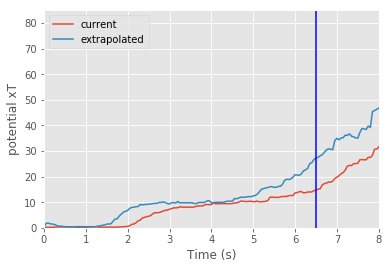

In [13]:
cur_threat, fut_threat = list(zip(*threats))
plt.plot(cur_threat, label='current')
plt.plot(fut_threat, label='extrapolated')

plt.xticks(np.arange(0, 200, 20), np.arange(0, 9))
plt.xlabel('Time (s)')
plt.ylabel('potential xT')
plt.ylim(bottom=0)
plt.legend()
plt.axvline(6.5*20, color='blue')
plt.xlim(0, 160)
plt.ylim(0, 85)

We see that the **Extrapolated Threat Potential (ETP) almost perfectly predicts the future Current Threat Potential (CTP)**. That is the desired result for a successful play.

## Detecting Forward Runs

OK, so ETP rising and CTP staying at the same level seems to be associated with space opening up. That could be the basis for a Potential Run metric.

Below is a plot of the difference between the two lines:

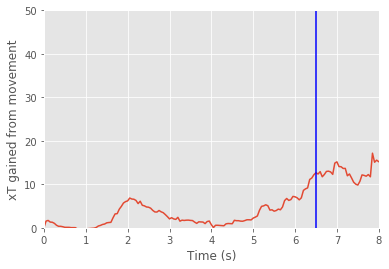

In [14]:
cur_threat, fut_threat = list(zip(*threats))
plt.plot(np.array(fut_threat)-np.array(cur_threat))

plt.xticks(np.arange(0, 300, 20), np.arange(0, 15))
plt.xlabel('Time (s)')
plt.ylabel('xT gained from movement')
plt.ylim(bottom=0)
plt.xlim(0, 160)

plt.axvline(6.5*20, color='blue')

Before Ronaldo’s run, there’s another moment where the expected threat is higher than the current threat, around the 2 second mark.

Let’s look at that moment:

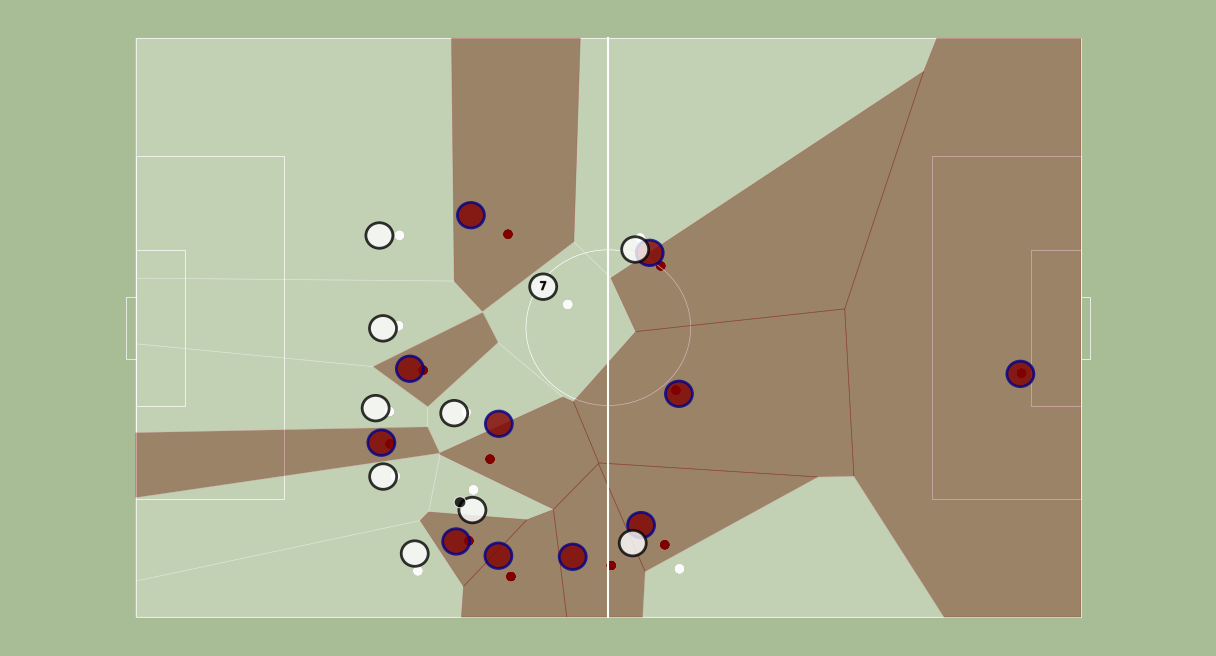

In [15]:
fig, ax, dfFrame, polygons = draw_voronoi(df, t=2, future=1)

Indeed, that is another run, this time by Ozil, but because it was on the wing and further from the goal the value of it was lower. Again, working as expected.

# Conclusion

Models that take into account positioning and movement allow us to value the space created by the attacking team, and potentially attribute that gain to an off-the-ball action. That is a new dimension that we can use to analyze the performance of teams that is not captured by the usual possession stats.

# Next Steps

Another area that is hard to measure is Defensive Positioning. I think this work can also be applied to that important dimension of play.
We can also apply this technique to value individual actions, translating the dynamic nature of this measure into easier to analyze events.